<a href="https://colab.research.google.com/github/aran3004/Autoencoders/blob/main/Deblur_Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Dependencies

In [52]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt

# Defining Hyperparameters

In [53]:
# None for now

# Downloading MNIST data

In [54]:
train_data = datasets.MNIST(root = './data', train = True,
                        transform = transforms.ToTensor(), download = True)

test_data = datasets.MNIST(root = './data', train = False,
                       transform = transforms.ToTensor())

# Implementing Data Loader

In [55]:
train_loader = DataLoader(train_data, batch_size = 32, shuffle = True)
test_loader = DataLoader(test_data, batch_size = 32, shuffle = True)

# Displaying some Data

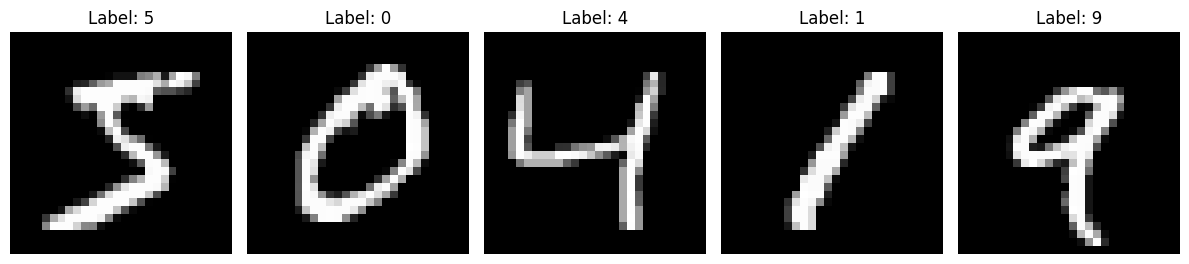

In [56]:
# Create a figure with 5 subplots
fig, axes = plt.subplots(1, 5, figsize=(12, 3))

# Display first 5 images
for i in range(5):
    image, label = train_data[i]
    # Convert the tensor to numpy array and reshape to 28x28
    image = image.squeeze().numpy()

    axes[i].imshow(image, cmap='gray')
    axes[i].set_title(f'Label: {label}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [57]:
print(f"Max value in the tensor: {torch.max(train_data[0][0])}")
print(f"Min value in the tensor: {torch.min(train_data[0][0])}")
print(f"Length of training data: {len(train_data)}")
print(f"Length of testing data: {len(test_data)}")

Max value in the tensor: 1.0
Min value in the tensor: 0.0
Length of training data: 60000
Length of testing data: 10000


# Adding Noise

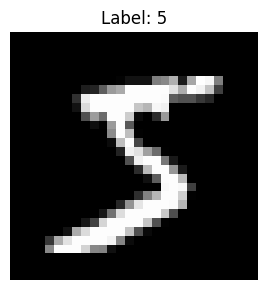

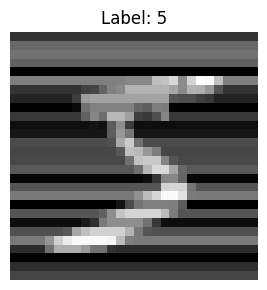

In [58]:
noisy_data_image, noisy_data_label = train_data[0]

fig, axes = plt.subplots(1, 1, figsize=(12, 3))

image, label = train_data[0]
# Convert the tensor to numpy array and reshape to 28x28
image = image.squeeze().numpy()

axes.imshow(image, cmap='gray')
axes.set_title(f'Label: {label}')
axes.axis('off')

plt.tight_layout()
plt.show()

for row in noisy_data_image:
    for pixel in row:
        pixel += torch.rand(1)

fig, axes = plt.subplots(1, 1, figsize=(12, 3))

# Convert the tensor to numpy array and reshape to 28x28
noisy_data_image = noisy_data_image.squeeze().numpy()

axes.imshow(noisy_data_image, cmap='gray')
axes.set_title(f'Label: {label}')
axes.axis('off')

plt.tight_layout()
plt.show()

In [59]:
print(f"Max value in the tensor: {torch.max(torch.tensor(noisy_data_image))}")
print(f"Min value in the tensor: {torch.min(torch.tensor(noisy_data_image))}")

Max value in the tensor: 1.9954771995544434
Min value in the tensor: 0.01738274097442627


Here we can see that the min and max values are not within the range of 0 and 1 as in the original so we will need to normalise the image

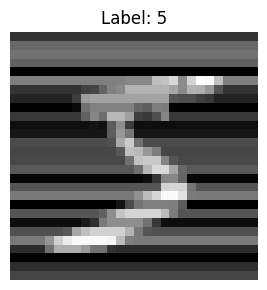

Max value in the tensor: 1.9954771995544434
Min value in the tensor: 0.01738274097442627


In [60]:
# normalise = torchvision.transforms.Normalize(mean=0.1307, std=0.3081)

normalise = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),  # Scales data into [0,1]
    # If you need further normalization, add it here
])

# noisy_data_image = normalise(torch.tensor(noisy_data_image).unsqueeze(0))
noisy_data_image = normalise(noisy_data_image)


fig, axes = plt.subplots(1, 1, figsize=(12, 3))

# Convert the tensor to numpy array and reshape to 28x28
noisy_data_image = noisy_data_image.squeeze().numpy()

axes.imshow(noisy_data_image, cmap='gray')
axes.set_title(f'Label: {label}')
axes.axis('off')

plt.tight_layout()
plt.show()

print(f"Max value in the tensor: {torch.max(torch.tensor(noisy_data_image))}")
print(f"Min value in the tensor: {torch.min(torch.tensor(noisy_data_image))}")

# Displaying Data with the Data Loader

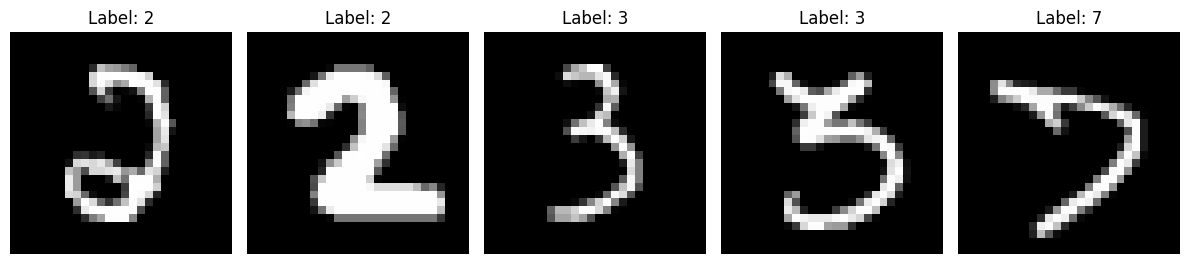

In [61]:
# Create a figure with 5 subplots
fig, axes = plt.subplots(1, 5, figsize=(12, 3))

# Get one batch from the dataloader
dataloader_iter = iter(train_loader)
batch_images, batch_labels = next(dataloader_iter)

# Display first 5 images from the batch
for i in range(5):
    image = batch_images[i]
    label = batch_labels[i]
    # Convert the tensor to numpy array and reshape to 28x28
    image = image.squeeze().numpy()

    axes[i].imshow(image, cmap='gray')
    axes[i].set_title(f'Label: {label}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

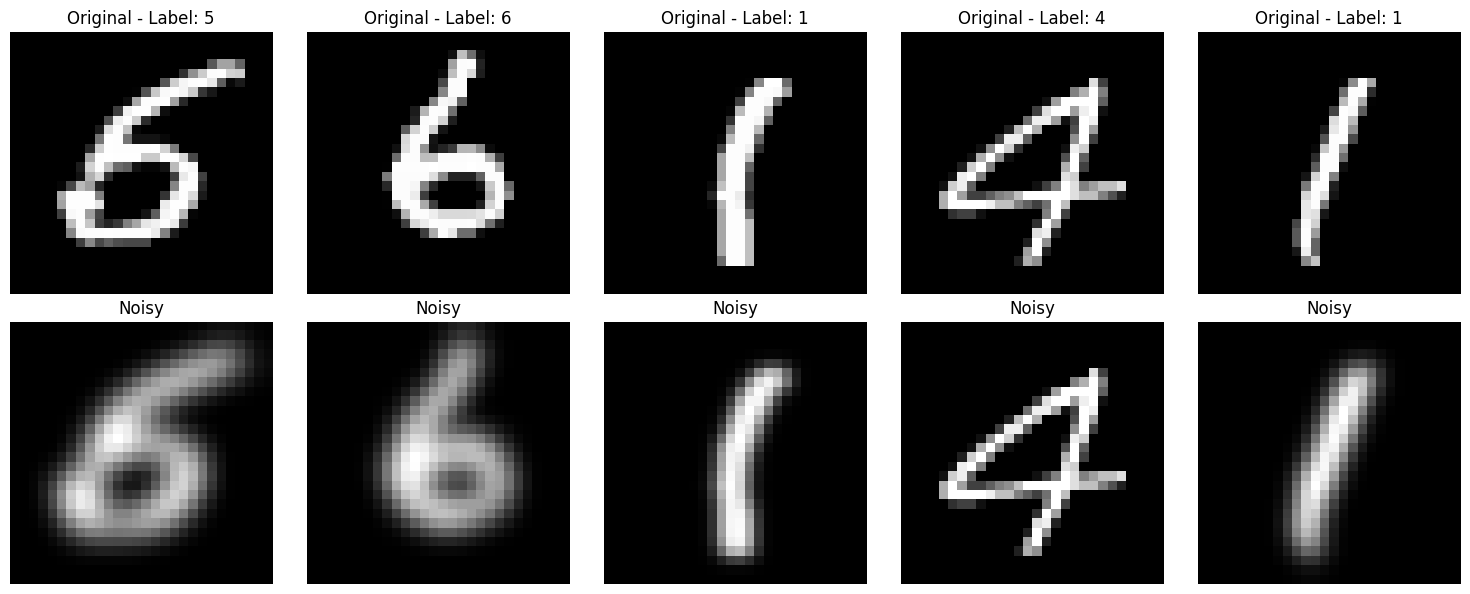

In [62]:
my_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.GaussianBlur(kernel_size=7),
    transforms.ToTensor()])

dataloader_iter = iter(train_loader)
batch_images, batch_labels = next(dataloader_iter)

# Apply the transform to the batch of images
noisy_batch_images = torch.stack([my_transform(img) for img in batch_images])

# Create figure with subplots - 2 rows, 5 columns
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

# Display 5 pairs of original and noisy images
for i in range(5):
    # Original image
    original_image = batch_images[i].squeeze().numpy()
    axes[0, i].imshow(original_image, cmap='gray')
    axes[0, i].set_title(f'Original - Label: {batch_labels[i]}')
    axes[0, i].axis('off')

    # Noisy image
    noisy_image = noisy_batch_images[i].squeeze().numpy()
    axes[1, i].imshow(noisy_image, cmap='gray')
    axes[1, i].set_title('Noisy')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

In [63]:
print(f"Max value in the tensor: {torch.max(noisy_batch_images)}")
print(f"Min value in the tensor: {torch.min(noisy_batch_images)}")

Max value in the tensor: 1.0
Min value in the tensor: 0.0


# Creating new dataset with blurry images as input and sharp images as output

In [69]:
# Create new datasets with different transforms
class DenoisingDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, idx):
        # Get the original image
        data, _ = self.dataset[idx]  # Ignore the label

        # Create the blurry version
        blurry = self.transform(data) if self.transform else data

        # Return blurry as input, original as target
        return blurry, data

    def __len__(self):
        return len(self.dataset)

# Create the datasets
train_denoising = DenoisingDataset(train_data, transform=my_transform)
test_denoising = DenoisingDataset(test_data, transform=my_transform)

# Create the DataLoaders
train_loader = DataLoader(train_denoising, batch_size=32, shuffle=True)
test_loader = DataLoader(test_denoising, batch_size=32, shuffle=False)

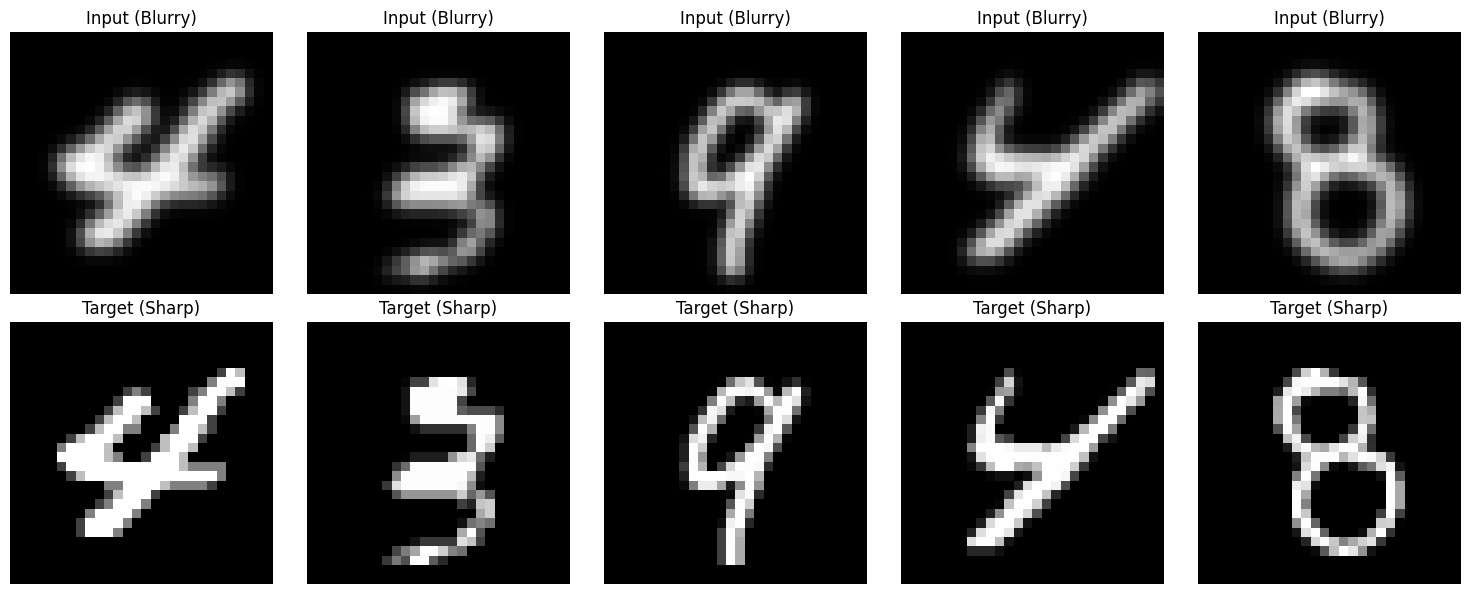

In [75]:
# Create figure with subplots - 2 rows, 5 columns
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

# Get a batch of data
train_iter = iter(train_loader)
blurry_batch, sharp_batch = next(train_iter)

# Display 5 pairs of blurry and sharp images
for i in range(5):
    # Blurry image (input)
    blurry_image = blurry_batch[i].squeeze().numpy()
    axes[0, i].imshow(blurry_image, cmap='gray')
    axes[0, i].set_title('Input (Blurry)')
    axes[0, i].axis('off')

    # Sharp image (target)
    sharp_image = sharp_batch[i].squeeze().numpy()
    axes[1, i].imshow(sharp_image, cmap='gray')
    axes[1, i].set_title('Target (Sharp)')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

In [77]:
class Autoencoder(nn.Module):
    def __init__(self):
      super().__init__()
      self.encoder = nn.Sequential(
          nn.Linear(28 * 28, 128),    # 28*28 (= 784) -> 128
          nn.ReLU(),
          nn.Linear(128, 64),
          nn.ReLU(),
          nn.Linear(64, 12),
          nn.ReLU(),
          nn.Linear(12, 3)            # 3 -> compressed representation
      )
      self.decoder = nn.Sequential(
          nn.Linear(3, 12),
          nn.ReLU(),
          nn.Linear(12, 64),
          nn.ReLU(),
          nn.Linear(64, 128),
          nn.ReLU(),
          nn.Linear(128, 28 * 28),
          nn.Sigmoid()        # to get values in range [0,1]
      )

    def forward(self, x):
      encoded = self.encoder(x)
      decoded = self.decoder(encoded)
      return decoded

In [78]:
model = Autoencoder()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

In [82]:
num_epochs = 3
outputs = []
for epoch in range(num_epochs):
    for data in iter(train_loader):
        blurry_img, sharp_image = data
        blurry_img = blurry_img.reshape(-1, 28*28)
        output = model(blurry_img)
        loss = criterion(output, sharp_image.reshape(-1, 28*28))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], loss:{loss.item():.4f}')
    outputs.append((epoch, output, sharp_image))

Epoch [1/3], loss:0.0444
Epoch [2/3], loss:0.0396
Epoch [3/3], loss:0.0358


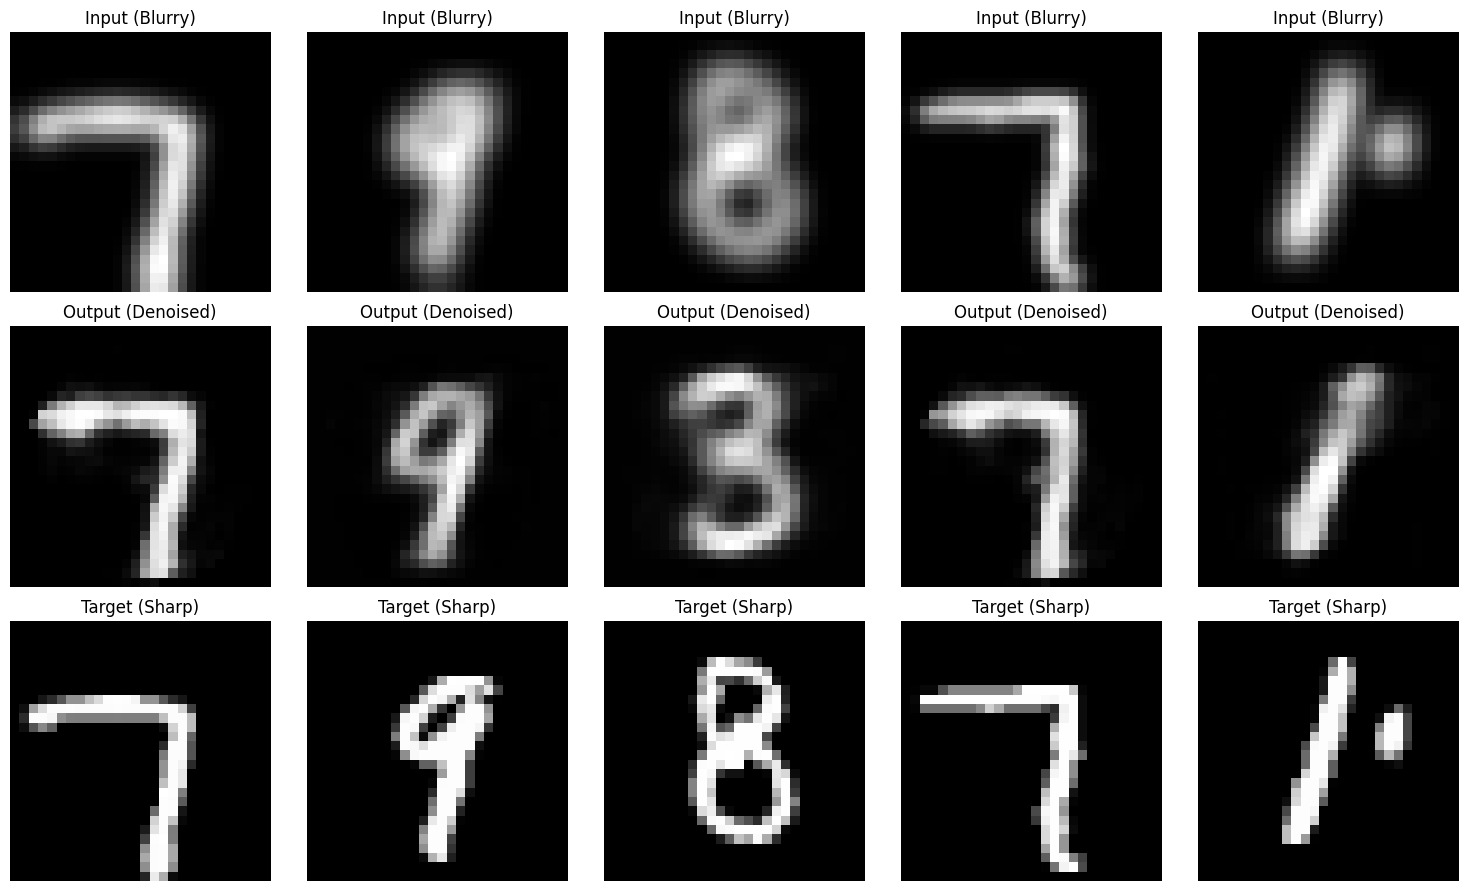

In [83]:
# Get the last batch results from outputs
final_epoch, final_output, final_sharp = outputs[-1]

# Create figure with subplots - 3 rows, 5 columns (input, output, target)
fig, axes = plt.subplots(3, 5, figsize=(15, 9))

# Display 5 sets of images
for i in range(5):
    # Original blurry image (input)
    blurry_image = blurry_img[i].reshape(28, 28).detach().numpy()
    axes[0, i].imshow(blurry_image, cmap='gray')
    axes[0, i].set_title('Input (Blurry)')
    axes[0, i].axis('off')

    # Model output (denoised)
    output_image = final_output[i].reshape(28, 28).detach().numpy()
    axes[1, i].imshow(output_image, cmap='gray')
    axes[1, i].set_title('Output (Denoised)')
    axes[1, i].axis('off')

    # Original sharp image (target)
    sharp_image = final_sharp[i].reshape(28, 28).detach().numpy()
    axes[2, i].imshow(sharp_image, cmap='gray')
    axes[2, i].set_title('Target (Sharp)')
    axes[2, i].axis('off')

plt.tight_layout()
plt.show()